# GDELT Knowledge Graph data pull

## From raw data

In [2]:
import pandas as pd
import numpy as np
import re
import time
import ast
import os
import urllib
from urllib.request import Request, urlopen
#outfile = '/datadrive/gdelt/climate_change.csv'
outfile = './local_debugging.csv'
errfile = './err_paths.txt'

In [3]:
os.getcwd()

'C:\\Users\\Leonardzh\\ssd500\\sesync\\codes\\gdelt-climate'

In [4]:
#assign fields name
fields = ['GKGRECORDID','DATE','SOURCECOLLECTIONIDENTIFIER','SOURCECOMMONNAME','DOCUMENTIDENTIFIER',
          'V1COUNTS','V2COUNTS','THEMES','V2THEMES','LOCATIONS','V2LOCATIONS',
          'PERSONS','V2PERSONS','ORGANIZATIONS','V2ORGANIZATIONS','TONE','V2DATES',
          'GCAM','SHARINGIMAGE','RELATEDIMAGES','SOCIALIMAGEEMBEDS','SOCIALVIDEOEMBEDS',
          'QUOTATIONS','ALLNAMES','AMOUNTS','TRANSLATIONINFO','EXTRASXML']

In [20]:
def extract_us_locations(full_loc_str):
    loc_str_list = full_loc_str.split(';')
    loc_us_list = []
    loc_us_dict = {}
    for loc_str in loc_str_list:
        if int(loc_str.split('#')[0]) == 2 or int(loc_str.split('#')[0]) == 3:
            #loc_us_list.append((loc_str.split('#')[0],loc_str.split('#')[1],loc_str.split('#')[5],loc_str.split('#')[6]))
            loc_us_dict[loc_str.split('#')[1]] = [loc_str.split('#')[0],loc_str.split('#')[1],loc_str.split('#')[5],loc_str.split('#')[6]]
    return loc_us_dict

In [21]:
def extract_theme_by_key(full_theme_str,key):
    theme_str_list = full_theme_str.split(';')
    flag = False
    match_themes = []
    for theme_str in theme_str_list:
        res = re.findall(f'(.*?{key}.*?),',theme_str)
        if len(res) > 0:
            match_themes.append(res[0])
            flag=True
    return flag,match_themes

In [41]:
#test performance for one file
gkg_pull_one = pd.read_csv('20201217153000.gkg.csv',sep='\t',engine='python',header=None)
gkg_pull_one.columns = fields
results = []
for record_tuple in gkg_pull_one[gkg_pull_one.SOURCECOLLECTIONIDENTIFIER==1].itertuples():
    full_theme_str = record_tuple[9]
    if not full_theme_str or full_theme_str is np.nan:
        #no theme
        pass
    else:
        #print(full_theme_str)
        #flag,match_themes = extract_theme_by_key(full_theme_str,'CLIMATE.?CHANGE')
        flag,match_themes = extract_theme_by_key(full_theme_str,'LOCAL')
        #flag2,match_themes2 = extract_theme_by_key(full_theme_str,'CLIMATECHANGE')
        
        if flag:
            #print(match_themes)
            full_loc_str = record_tuple[11]
            #print(full_loc_str)
            if not full_loc_str or full_loc_str is np.nan:
                pass
            else:
                us_locations = extract_us_locations(full_loc_str)
                if (len(us_locations) > 0):
                    results.append((record_tuple[1],record_tuple[4],record_tuple[5],us_locations))

len(results)

28

In [45]:
pd.DataFrame(results).loc[24][2]

'https://www.cbs8.com/article/news/health/coronavirus/close-but-not-yet-deal-near-on-covid-19-relief-bill-second-stimulus-check-thursday-updates/507-f895cb0d-a6d2-4956-b167-5c59d50e0a89'

In [23]:
pd.DataFrame(results).to_csv(outfile,index_label=False)

In [24]:
df = pd.read_csv(outfile)

"{'Cannon Beach, Oregon, United States': ['3', 'Cannon Beach, Oregon, United States', '45.8918', '-123.962'], 'Haystack Rock, Oregon, United States': ['3', 'Haystack Rock, Oregon, United States', '43.0862', '-124.438'], 'California, United States': ['2', 'California, United States', '36.17', '-119.746'], 'Oregon, United States': ['2', 'Oregon, United States', '44.5672', '-122.127'], 'Washington, Washington, United States': ['3', 'Washington, Washington, United States', '38.8951', '-77.0364']}"

In [28]:
ast.literal_eval(df['2'][0])

{'Cannon Beach, Oregon, United States': ['3',
  'Cannon Beach, Oregon, United States',
  '45.8918',
  '-123.962'],
 'Haystack Rock, Oregon, United States': ['3',
  'Haystack Rock, Oregon, United States',
  '43.0862',
  '-124.438'],
 'California, United States': ['2',
  'California, United States',
  '36.17',
  '-119.746'],
 'Oregon, United States': ['2',
  'Oregon, United States',
  '44.5672',
  '-122.127'],
 'Washington, Washington, United States': ['3',
  'Washington, Washington, United States',
  '38.8951',
  '-77.0364']}

In [32]:
len(lines)

598668

In [54]:
import pandas as pd
import numpy as np
import re
import time
import ast
#outfile = '/datadrive/liuz/climate_change_news_us_loca.csv'
outfile = './append_debugging_climate_change_news_us_loca.csv'
#errfile = '/datadrive/liuz/climate_change_news_us_errfile.txt'
errfile = './error_debugging_climate_change_news_us_err.csv'
#assign fields name
fields = ['GKGRECORDID','DATE','SOURCECOLLECTIONIDENTIFIER','SOURCECOMMONNAME','DOCUMENTIDENTIFIER',
          'V1COUNTS','V2COUNTS','THEMES','V2THEMES','LOCATIONS','V2LOCATIONS',
          'PERSONS','V2PERSONS','ORGANIZATIONS','V2ORGANIZATIONS','TONE','V2DATES',
          'GCAM','SHARINGIMAGE','RELATEDIMAGES','SOCIALIMAGEEMBEDS','SOCIALVIDEOEMBEDS',
          'QUOTATIONS','ALLNAMES','AMOUNTS','TRANSLATIONINFO','EXTRASXML']

def extract_us_locations(full_loc_str):
    loc_str_list = full_loc_str.split(';')
    loc_us_list = []
    loc_us_dict = {}
    for loc_str in loc_str_list:
        if int(loc_str.split('#')[0]) == 2 or int(loc_str.split('#')[0]) == 3:
            #loc_us_list.append((loc_str.split('#')[0],loc_str.split('#')[1],loc_str.split('#')[5],loc_str.split('#')[6]))
            loc_us_dict[loc_str.split('#')[1]] = [loc_str.split('#')[0],loc_str.split('#')[1],loc_str.split('#')[5],loc_str.split('#')[6]]
    return loc_us_dict

def extract_theme_by_key(full_theme_str,key):
    theme_str_list = full_theme_str.split(';')
    flag = False
    match_themes = []
    for theme_str in theme_str_list:
        res = re.findall(f'(.*?{key}.*?),',theme_str)
        if len(res) > 0:
            match_themes.append(res[0])
            flag=True
    return flag,match_themes

#get all gkg file paths and download latest 500
gkg_file_list = []
with open('masterfilelist.txt') as fo:
    lines = fo.readlines()
for line in lines:
    url = line.split(' ')[-1].rstrip('\n')
    res = re.match('.*.gkg..*',url)
    if res:
        #print(url)
        gkg_file_list.append(url)

# extract geoinformation for climate related news

error_fpaths = []
t0 = time.time()
count = 0
total = len(gkg_file_list)
for fpath in gkg_file_list[-10:]:
    results = []
    count += 1
    try:
        gkg_pull_one = pd.read_csv(fpath,sep='\t',engine='python',header=None,encoding='latin_1')
    except:
        print(f'error met {fpath}')
        error_fpaths.append(fpath)
        continue
    gkg_pull_one.columns = fields
    #test performance for one file
    for record_tuple in gkg_pull_one[gkg_pull_one.SOURCECOLLECTIONIDENTIFIER == 1].itertuples():
        full_theme_str = record_tuple[9]
        #print(full_theme_str)
        if not full_theme_str or full_theme_str is np.nan:
            #no theme
            pass
        else:
            #print(len(full_theme_str))
            flag,match_themes = extract_theme_by_key(full_theme_str,'CLIMATE.?CHANGE')
            if flag:
                full_loc_str = record_tuple[11]
                if not full_loc_str or full_loc_str is np.nan:
                    pass
                else:
                    us_locations = extract_us_locations(full_loc_str)
                    if (len(us_locations) > 0):
                        results.append({'nid':record_tuple[1],'domain':record_tuple[4],'url':record_tuple[5],'locations':us_locations})
    t1 = time.time()
    
    print(f'{count}/{total} done with valid news count {len(results)}. {len(error_fpaths)} error loading. {fpath} accumulated run time {t1-t0}s ')

    pd.DataFrame(results).to_csv(outfile,mode = 'a',index=False,header=False)
    with open(errfile, 'w') as f:
        for item in error_fpaths:
            f.write(f"{item}\n")

1/199541 done with valid news count 16. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217151500.gkg.csv.zip accumulated run time 3.587791919708252s 
2/199541 done with valid news count 19. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217153000.gkg.csv.zip accumulated run time 11.145204067230225s 
3/199541 done with valid news count 11. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217154500.gkg.csv.zip accumulated run time 14.640212059020996s 
4/199541 done with valid news count 21. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217160000.gkg.csv.zip accumulated run time 20.565479040145874s 
5/199541 done with valid news count 14. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217161500.gkg.csv.zip accumulated run time 28.325597047805786s 
6/199541 done with valid news count 12. 0 error loading. http://data.gdeltproject.org/gdeltv2/20201217163000.gkg.csv.zip accumulated run time 32.52955603599548s 
7/199541 done with valid

In [6]:
ccresults =pd.read_csv('../../data/climate_change_news_us_loca.csv',header=None)
ccresults.columns = ['nid','domain','url','dict_loc']

ccresults.head()

,nid,domain,url,dict_loc
0,20150218230000-221,insidebelleville.com,http://www.insidebelleville.com/news-story/534...,"{'Alaskan, United States': ['2', 'Alaskan, Uni..."
1,20150218230000-365,huffingtonpost.com,http://www.huffingtonpost.com/2015/02/18/huffp...,"{'Capitol Hill, District Of Columbia, United S..."
2,20150218230000-510,salon.com,http://www.salon.com/2015/02/17/heat_waves_dow...,"{'New York, United States': ['2', 'New York, U..."
3,20150218230000-906,courant.com,http://www.courant.com/opinion/op-ed/hc-op-tho...,"{'Washington, District Of Columbia, United Sta..."
4,20150218230000-1109,huffingtonpost.com,http://www.huffingtonpost.com/carol-kellermann...,"{'Boston, Massachusetts, United States': ['3',..."


In [7]:
ccexpand_records = []
for entry in ccresults.itertuples():
    #print(entry[4])
    nid = entry[1]
    url = entry[3]
    domain = entry[2]
    dict_loca = ast.literal_eval(entry[4])
    for loc in list(dict_loca.values()):
        place = loc[1]
        lat = loc[2]
        lng = loc[3]
        ccexpand_records.append({'nid':nid,'domain':domain,'url':url,'place':place,'lat':lat,'lng':lng})

In [8]:
ccfull_df = pd.DataFrame(ccexpand_records)

In [9]:
ccfull_df.describe()

,nid,domain,url,place,lat,lng
count,14294532,14293205,14294532,14294532,14294532,14294532
unique,3432899,31127,3435942,90374,64311,61952
top,20200620183000-913,yahoo.com,https://www.nj.com/news/2020/06/nj-places-of-w...,"California, United States",38.8951,-77.0364
freq,218,151309,218,807786,1564576,1564670


In [53]:
ccresults['dt'] = ccresults['nid'].map(lambda x: nid_to_datetime(x))

In [54]:
ccresults['int_days'] = ccresults['dt'].map(lambda x: dt_to_yymmdd_int(x))

In [55]:
ccresults

,nid,domain,url,dict_loc,dt,int_days
0,20150218230000-221,insidebelleville.com,http://www.insidebelleville.com/news-story/534...,"{'Alaskan, United States': ['2', 'Alaskan, Uni...",2015-02-18 23:00:00,20150218
1,20150218230000-365,huffingtonpost.com,http://www.huffingtonpost.com/2015/02/18/huffp...,"{'Capitol Hill, District Of Columbia, United S...",2015-02-18 23:00:00,20150218
2,20150218230000-510,salon.com,http://www.salon.com/2015/02/17/heat_waves_dow...,"{'New York, United States': ['2', 'New York, U...",2015-02-18 23:00:00,20150218
3,20150218230000-906,courant.com,http://www.courant.com/opinion/op-ed/hc-op-tho...,"{'Washington, District Of Columbia, United Sta...",2015-02-18 23:00:00,20150218
4,20150218230000-1109,huffingtonpost.com,http://www.huffingtonpost.com/carol-kellermann...,"{'Boston, Massachusetts, United States': ['3',...",2015-02-18 23:00:00,20150218
...,...,...,...,...,...,...
3435937,20201217173000-2033,prnewswire.com,https://www.prnewswire.com/news-releases/advan...,"{'Texas, United States': ['2', 'Texas, United ...",2020-12-17 17:30:00,20201217
3435938,20201217173000-2071,reuters.com,https://www.reuters.com/article/usa-biden-rega...,"{'Environmental Protection Agency, District Of...",2020-12-17 17:30:00,20201217
3435939,20201217173000-2087,autoblog.com,https://www.autoblog.com/2020/12/17/ford-bronc...,"{'Dearborn, Michigan, United States': ['3', 'D...",2020-12-17 17:30:00,20201217
3435940,20201217173000-2104,msn.com,https://www.msn.com/en-gb/lifestyle/style/dodg...,"{'New York, United States': ['2', 'New York, U...",2020-12-17 17:30:00,20201217


In [67]:
ccresults['deltaday'] = ccresults['dt'].map(lambda x: dt_to_day_delta(x))

ccresults.groupby('int_days').agg({'domain':'count'}).reset_index()

import seaborn as sns

sns.kdeplot(data=ccresults, x="deltaday",fill=True)

In [35]:
ccfull_df['dt'] = ccfull_df['nid'].map(lambda x: nid_to_datetime(x))

In [44]:
ccfull_df['int_days'] = ccfull_df['dt'].map(lambda x: dt_to_yymmdd_int(x))

In [49]:
ccfull_df['suffix_id'] = ccfull_df['nid'].map(lambda x: extract_nid_suffix(x))

In [51]:
ccfull_df.groupby(['int_days','suffix_id']).count()

In [29]:
nid_str = ccfull_df['nid'][0]
nid_str

'20150218230000-221'

In [31]:
dt_str = nid_str.split('-')[0]

In [32]:
dt_str

'20150218230000'

In [37]:
dt = datetime.datetime.strptime(dt_str, '%Y%m%d%H%M%S')

In [38]:
dt

datetime.datetime(2015, 2, 18, 23, 0)

In [30]:
import datetime

In [ ]:
datetime.datetime()

In [48]:
extract_nid_suffix(nid_str)

221

In [46]:
def extract_nid_suffix(nid_str):
    id_str = nid_str.split('-')[1]
    return int(id_str)

In [34]:
def nid_to_datetime(nid_str):
    import datetime
    dt_str = nid_str.split('-')[0]
    dt = datetime.datetime.strptime(dt_str, '%Y%m%d%H%M%S')
    return dt

20150218

In [60]:
dt

datetime.datetime(2015, 2, 18, 23, 0)

In [64]:
(dt-datetime.datetime(2015,1,1)).days

48

In [65]:
def dt_to_day_delta(dt):
    return (dt-datetime.datetime(2015,1,1)).days

In [43]:
def dt_to_yymmdd_int(dt):
    return dt.year*10000+dt.month*100+dt.day

In [ ]:
Boulder, Colorado, United States
Aliso Canyon, California, United States

<ipython-input-75-c5d6956bc895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['deltaday'] = sample_df['dt'].map(lambda x: dt_to_day_delta(x))


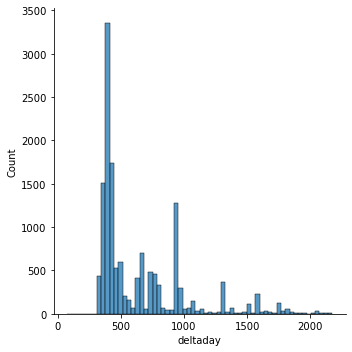

In [75]:
sample_df = ccfull_df.query('place=="Aliso Canyon, California, United States"')
sample_df['deltaday'] = sample_df['dt'].map(lambda x: dt_to_day_delta(x))

import seaborn as sns

sns.displot(data=sample_df, x="deltaday",fill=True,kind='hist')

<ipython-input-72-804acf9ba1c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['deltaday'] = sample_df['dt'].map(lambda x: dt_to_day_delta(x))


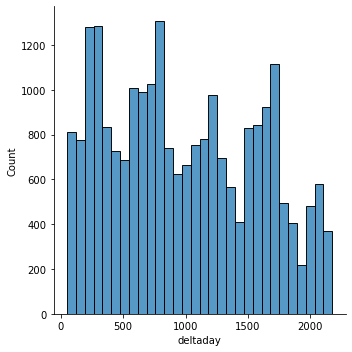

In [72]:
sample_df = ccfull_df.query('place=="Boulder, Colorado, United States"')
sample_df['deltaday'] = sample_df['dt'].map(lambda x: dt_to_day_delta(x))

import seaborn as sns

sns.displot(data=sample_df, x="deltaday",fill=True,kind='hist')

In [76]:
ccfull_df.dtypes

nid                  object
domain               object
url                  object
place                object
lat                  object
lng                  object
dt           datetime64[ns]
int_days              int64
suffix_id             int64
dtype: object

In [77]:
place_freq = ccfull_df.groupby('place').agg({'lat':'first','lng':'first','nid':'count'}).reset_index().sort_values('nid',ascending=False)[['place','nid','lat','lng']].rename(columns={'nid':'count'})

In [83]:
float('-119.746')

-119.746

In [93]:
place_freq = place_freq.query('lng!="" and lat!=""')

In [94]:
for rid,row in place_freq.iterrows():
    try:
        lat = float(row['lat'])
        lng = float(row['lng'])
    except ValueError:
        print ("error on line",row)

In [96]:
place_freq = place_freq.astype({'lat':'float','lng':'float'})

In [97]:
place_freq.query('count>1000').to_csv('../../data/processed/place_freq_cc_us.csv',index=False)

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

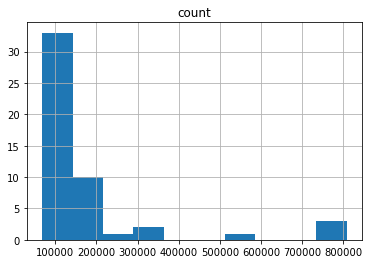

In [24]:
place_freq.iloc[0:50].hist('count')

In [12]:
len(ccfull_df.place.unique())

90374

In [77]:
ccfull_df.groupby('domain').count().reset_index().sort_values('place',ascending=False)

,domain,nid,url,place,lat,lng
30857,yahoo.com,151309,151309,151309,151309,151309
4612,catholicsentinel.org,117640,117640,117640,117640,117640
17456,msn.com,105128,105128,105128,105128,105128
12507,iheart.com,100315,100315,100315,100315,100315
29878,wickedlocal.com,80845,80845,80845,80845,80845
...,...,...,...,...,...,...
12997,insurance.1asig.ro,1,1,1,1,1
23702,skepticalraptor.com,1,1,1,1,1
13002,insuranceerm.com,1,1,1,1,1
13007,insurancesavingsinstitute.com,1,1,1,1,1


In [68]:
results = pd.read_csv('../../data/raw/gdelt/local_news_us_loca.csv',header=None)
results.columns = ['nid','domain','url','dict_loc']

results.head()

In [72]:

dict_loca = ast.literal_eval(results.loc[4]['dict_loc'])
list(dict_loca.values())

[['3', 'Atlanta, Georgia, United States', '33.749', '-84.388'],
 ['2', 'Georgia, United States', '32.9866', '-83.6487'],
 ['3', 'South Bend, Indiana, United States', '41.6834', '-86.25'],
 ['2', 'Michigan, United States', '43.3504', '-84.5603'],
 ['2', 'Indiana, United States', '39.8647', '-86.2604']]

In [74]:
for loc in list(dict_loca.values()):
    print(loc[1],loc[2],loc[3])

Atlanta, Georgia, United States 33.749 -84.388
Georgia, United States 32.9866 -83.6487
South Bend, Indiana, United States 41.6834 -86.25
Michigan, United States 43.3504 -84.5603
Indiana, United States 39.8647 -86.2604


In [20]:
expand_records = []
for entry in results.itertuples():
    #print(entry[4])
    # nid = entry[1]
    url = entry[3]
    domain = entry[2]
    dict_loca = ast.literal_eval(entry[4])
    for loc in list(dict_loca.values()):
        place = loc[1]
        lat = loc[2]
        lng = loc[3]
        expand_records.append({'domain':domain,'url':url,'place':place,'lat':lat,'lng':lng})

In [21]:
full_df = pd.DataFrame(expand_records)

In [22]:
full_df.describe()

,domain,url,place,lat,lng
count,21289052,21291478,21291478,21291478,21291478
unique,27003,4504053,129557,81731,84667
top,gwdtoday.com,https://www.nj.com/news/2020/05/where-is-the-c...,"New York, United States",38.8951,-77.0364
freq,302420,301,1175915,1390898,1390926


In [53]:
domain_count = full_df.groupby('domain').count().reset_index().sort_values('place',ascending=False)

In [55]:
domain_count[2000:2012]

,domain,url,place,lat,lng
1471,amny.com,2320,2320,2320,2320
6232,delrionewsherald.com,2319,2319,2319,2319
416,921theticket.com,2318,2318,2318,2318
3455,burlingtonfreepress.com,2316,2316,2316,2316
21998,texasguardian.com,2316,2316,2316,2316
8545,fox42kptm.com,2315,2315,2315,2315
25304,wbch.com,2315,2315,2315,2315
17346,orlandoweekly.com,2314,2314,2314,2314
8524,fox17online.com,2314,2314,2314,2314
12151,kdwn.com,2314,2314,2314,2314


In [67]:
for idx in range(2000,2012,1):
    sample_domain = domain_count.iloc[idx]['domain']

    #urls_gwd = full_df.query('domain == "gwdtoday.com"')
    urls_sample = full_df.query('domain == @sample_domain')

    #urls_gwd.groupby(['lat','lng']).count().reset_index().to_csv('../../data/raw/gdelt/loca_gwdtoday.csv')
    urls_sample.groupby(['lat','lng']).count().reset_index().to_csv(f'../../data/raw/gdelt/local_domain/loca_{sample_domain}.csv')

In [49]:
counter=0
for row in urls_iheart.itertuples():
    
    #print (row[40:42],row[44],row[-1])
#     if counter < 225:
#         counter+=1
#         continue
    url = row[2]
    if counter % 1000==0:
        print(counter)

    try:
        req = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        resp = urlopen(req)
        respData = resp.read()

        paragraphs = re.findall(r'<p>(.*?)</p>',str(respData))
        rawtext=''
        for eachP in paragraphs:
            rawtext+=eachP.replace("|", " ")
        print(counter,url,rawtext)
    except urllib.request.HTTPError as e:
        pass
        #print('http error')
    except Exception as e:
        print(f"Unexpected error {e} at {url}")
    counter +=1
#     if counter > 20:
#         break


0
Unexpected error <urlopen error [Errno -2] Name or service not known> at http://sunny935.iheart.com/articles/features-sunny-492549/virginia-vfw-post-may-have-violated-14641241/
Unexpected error <urlopen error [Errno -2] Name or service not known> at http://sunny935.iheart.com/articles/features-sunny-492549/virginia-vfw-post-may-have-violated-14641241/
Unexpected error <urlopen error [Errno -2] Name or service not known> at http://newstalk1440.iheart.com/articles/247-california-news-497170/sf-city-hall-to-stay-purple-14642409/
Unexpected error <urlopen error [Errno -2] Name or service not known> at http://newstalk1440.iheart.com/articles/247-california-news-497170/sf-city-hall-to-stay-purple-14642409/
816 http://talk910.iheart.com/articles/247-california-news-497170/sf-city-hall-to-stay-purple-14642409/ 
817 http://talk910.iheart.com/articles/247-california-news-497170/sf-city-hall-to-stay-purple-14642409/ 
867 http://talk910.iheart.com/onair/the-mo-kelly-experience-57554/san-francisc

KeyboardInterrupt: 

In [12]:
full_df.groupby('domain').count().reset_index().sort_values('place',ascending=False)

,domain,place,lat,lng
9725,gwdtoday.com,302420,302420,302420
10784,iheart.com,195976,195976,195976
25464,web.nmusd.us,187845,187845,187845
15219,msn.com,178674,178674,178674
26768,yahoo.com,174605,174605,174605
...,...,...,...,...
10197,hiphollywood.com,1,1,1
3862,capitalspectator.com,1,1,1
10200,hiphopnewsfeed.com,1,1,1
20803,sonic1029.com,1,1,1


In [9]:
len(full_df.domain.unique())

27004

In [34]:
pd.DataFrame(results).to_csv(outfile,index=False)

In [38]:
with open(errfile, 'w') as f:
    for item in error_fpaths:
        f.write(f"{item}\n")

In [33]:
pd.DataFrame(results)

,0,1,2
0,20201216000000-107,https://www.upi.com/Top_News/US/2020/12/15/Bid...,"{'Texas, United States': ['2', 'Texas, United ..."
1,20201216000000-245,https://www.usatoday.com/story/news/politics/e...,"{'Texas, United States': ['2', 'Texas, United ..."
2,20201216000000-297,http://www.msn.com/en-us/news/politics/joe-bid...,"{'Department Of Energy, District Of Columbia, ..."
3,20201216000000-371,https://www.sciencemag.org/news/2020/12/us-age...,"{'Great Lakes, Florida, United States': ['3', ..."
4,20201216000000-389,https://www.nbcchicago.com/news/national-inter...,"{'Texas, United States': ['2', 'Texas, United ..."
...,...,...,...
2487,20201217173000-2033,https://www.prnewswire.com/news-releases/advan...,"{'Texas, United States': ['2', 'Texas, United ..."
2488,20201217173000-2071,https://www.reuters.com/article/usa-biden-rega...,"{'Environmental Protection Agency, District Of..."
2489,20201217173000-2087,https://www.autoblog.com/2020/12/17/ford-bronc...,"{'Dearborn, Michigan, United States': ['3', 'D..."
2490,20201217173000-2104,https://www.msn.com/en-gb/lifestyle/style/dodg...,"{'New York, United States': ['2', 'New York, U..."


## From Google BigQuery

In [ ]:
import os
print(os.getcwd())

In [ ]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
client = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

# Perform a query.
QUERY = (

'''
    WITH subset_query AS (
  SELECT *  from gdelt-bq.gdeltv2.gkg 
  where DATE>20170302000000 and DATE < 20170304000000 
 limit 200
)
    select gid,regex_extr, ANY_VALUE(code) as level_code,ANY_VALUE(url) as url,ANY_VALUE(location) as raw_loc from 
    (select url,gid,location,regexp_extract(location, r'^[2-3]#(.*?)#') as regex_extr,
    regexp_extract(location, r'^([2-3])#.*?') as code 
    from
    (select subset_query.GKGRECORDID as gid ,subset_query.DocumentIdentifier as url, SPLIT(subset_query.V2Locations, ';') as split_loc
    
    from subset_query) CROSS JOIN UNNEST(split_loc) as location)
    where regex_extr IS NOT NULL
    group by gid,regex_extr
'''

)
#print(QUERY)

In [ ]:
dataframe = (
    client.query(QUERY)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
#print(dataframe.head())